### OCR
---
- mkdir -p ~/aiffel/ocr_python

#### 구글 OCR API
- pip install --upgrade google-api-python-client
- pip install google-cloud-vision

- [구글 API 사용법](http://egloos.zum.com/mcchae/v/11342622)
- 인증키 경로 등록 후 커널 재기동 / export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json   

- 환경변수 설정 echo "export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json" >> ~/.bashrc

In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [3]:
# 유료로 전환시 가능
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/graph.png' 

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
#detect_text(path)

### keras-ocr 
- pip install keras-ocr
- echo "export TF_FORCE_GPU_ALLOW_GROWTH=true" >> ~/.bashrc
- echo $TF_FORCE_GPU_ALLOW_GROWTH 

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/ssac24/.keras-ocr/craft_mlt_25k.h5
Looking for /home/ssac24/.keras-ocr/crnn_kurapan.h5


In [2]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/home/ssac24/anaconda3/envs/aiffel/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


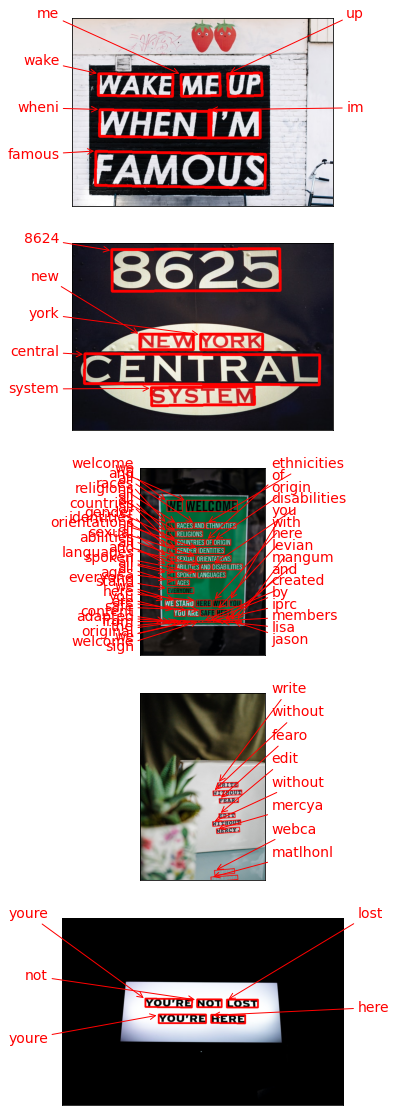

In [3]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 테서랙트

#### 테서랙트 설치
- sudo apt install tesseract-ocr
- sudo apt install libtesseract-dev

#### 테서랙트 파이썬 wrapper 설치
- pip install pytesseract

#### 테서렉트 한글 언어팩 설치
- sudo apt install tesseract-ocr-kor

#### 테서랙트로 문자 검출하고 이미지 자르기 (detection)

In [4]:
# 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    # 기본적으로 image_to_data를 씀
    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        # Output을 이용해 Dict형태로 출력
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/graph.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/ssac24/aiffel/ocr_python/0000.png
/home/ssac24/aiffel/ocr_python/0001.png
/home/ssac24/aiffel/ocr_python/0002.png
/home/ssac24/aiffel/ocr_python/0003.png
/home/ssac24/aiffel/ocr_python/0004.png
/home/ssac24/aiffel/ocr_python/0005.png
/home/ssac24/aiffel/ocr_python/0006.png
/home/ssac24/aiffel/ocr_python/0007.png
/home/ssac24/aiffel/ocr_python/0008.png
/home/ssac24/aiffel/ocr_python/0009.png
/home/ssac24/aiffel/ocr_python/0010.png
/home/ssac24/aiffel/ocr_python/0011.png
/home/ssac24/aiffel/ocr_python/0012.png
/home/ssac24/aiffel/ocr_python/0013.png
/home/ssac24/aiffel/ocr_python/0014.png
/home/ssac24/aiffel/ocr_python/0015.png
/home/ssac24/aiffel/ocr_python/0016.png
/home/ssac24/aiffel/ocr_python/0017.png
/home/ssac24/aiffel/ocr_python/0018.png
/home/ssac24/aiffel/ocr_python/0019.png
/home/ssac24/aiffel/ocr_python/0020.png
/home/ssac24/aiffel/ocr_python/0021.png
/home/ssac24/aiffel/ocr_python/0022.png
/home/ssac24/aiffel/ocr_python/0023.png
/home/ssac24/aiffel/ocr_python/0024.png


#### 테서랙트로 잘린 이미지에서 단어 인식하기

In [5]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

ee Cl ee  CUClclClClt—“‘i‘“R RR

5

Ana(cony

‘ola

a

figure

Title

——U__ weet


|

Major

__— 4

n@iso))

sulisteia

_ — «


Major

tic ke



Axes

RRR RES



{>

pH V-<+-

a. a

i

jj -™» ft

f «As i “™st>j> 4. sf”,

=

= -

= StF = Ff “Fy

+

Misc

witty

Nttp://rmalpiortip org

Done


### 프로젝트 : 다양한 OCR모델 비교

#### 1. keras-ocr

In [22]:
import matplotlib.pyplot as plt
import keras_ocr


image_urls = [
  './aiffel/ocr_python/ocr1.jpg',
  './aiffel/ocr_python/ocr2.jpg',
  './aiffel/ocr_python/ocr3.jpg',
  './aiffel/ocr_python/ocr4.jpg',
  './aiffel/ocr_python/ocr5.jpg',
  './aiffel/ocr_python/ocr6.jpg',
  './aiffel/ocr_python/ocr7.jpg',
  './aiffel/ocr_python/ocr8.jpg',
  './aiffel/ocr_python/ocr9.jpg',
  './aiffel/ocr_python/ocr10.jpg',  
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

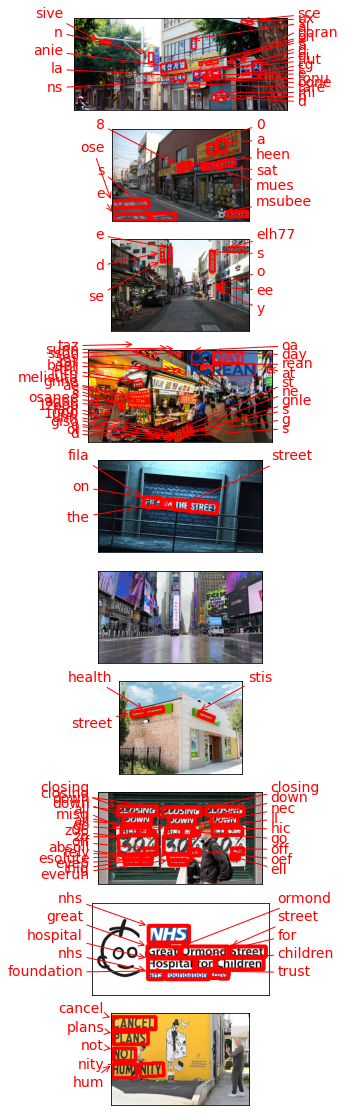

In [23]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

#### 2. tesseract-ocr

In [51]:
# 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    # 기본적으로 image_to_data를 씀
    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        # Output을 이용해 Dict형태로 출력
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/ocr11.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/ssac24/aiffel/ocr_python/0000.png


In [52]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

이

Done


### 정리
- 구글 API는 유료전환 문제로 인해 사용해보지 못했음.
- keras에서는 영어로 만들어져있어 영어를 정확하게 인식하는 편이었으나 한국어는 패치가 되지 않아 인식을 사용해볼 수 없었다.
- 테서렉트의 경우는 이미지 분할 후 인식하는 것이라 그런가 정확한 문장 단위의 선명한 이미지가 아니거나 1,2개의 단어만 있을 경우엔 제대로 인식하지 못했다.